# Árbol de decisión

## 1. Obtención de los datos de entrada

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [17]:
import os

data_rute = os.path.join('Datasets', 'artists_billboard_fix3.csv')
artists_billboard = pd.read_csv(data_rute)

artists_billboard.shape

(635, 11)

## 2. Análisis exploratorio inicial

In [18]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [19]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

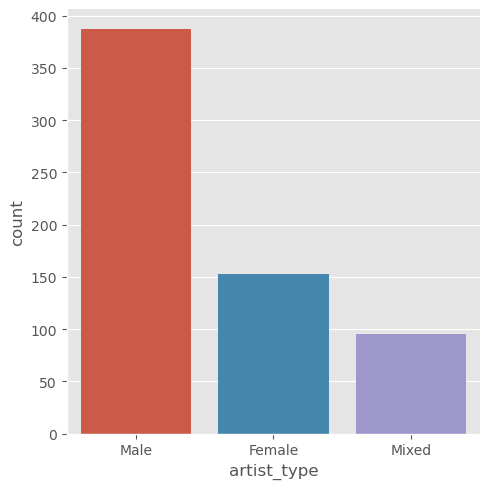

In [20]:
sns.catplot(x='artist_type', data=artists_billboard, kind='count')

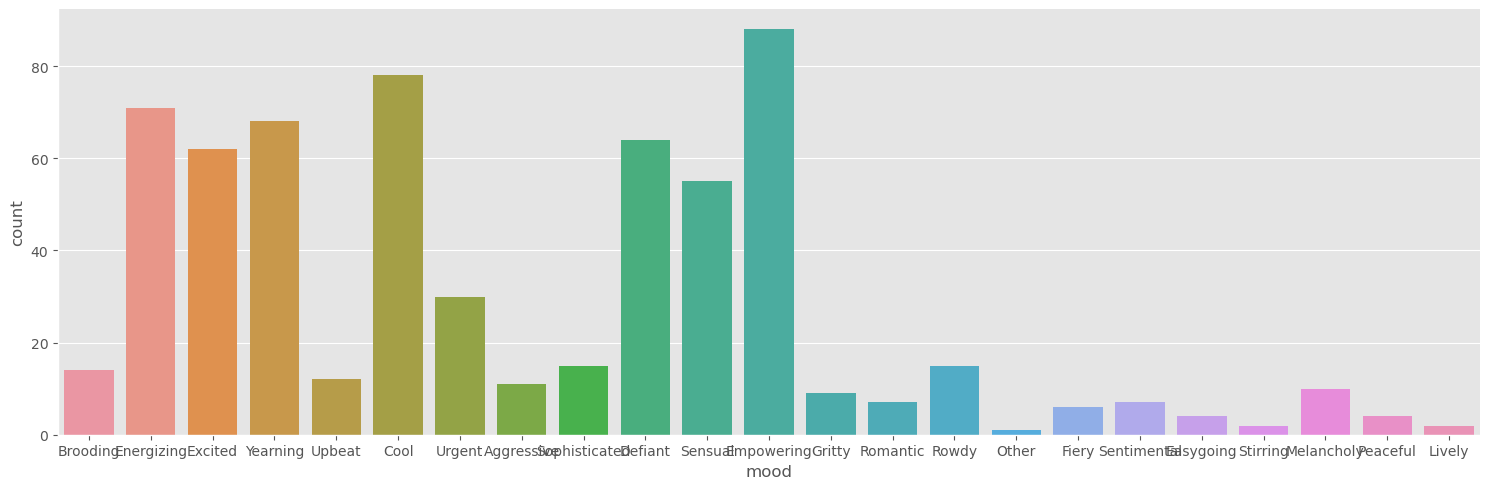

In [21]:
sns.catplot(x='mood', data=artists_billboard, kind='count', aspect=3)

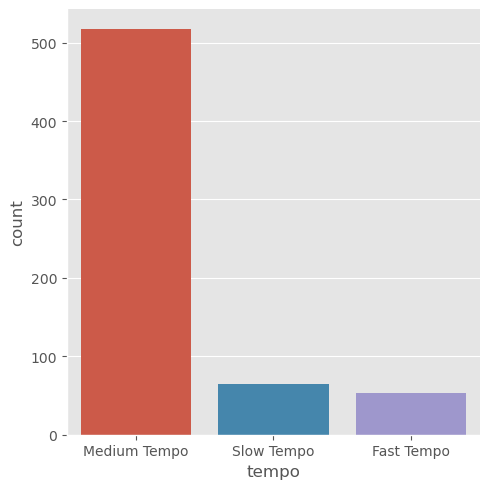

In [22]:
sns.catplot(x='tempo', data=artists_billboard, kind='count')

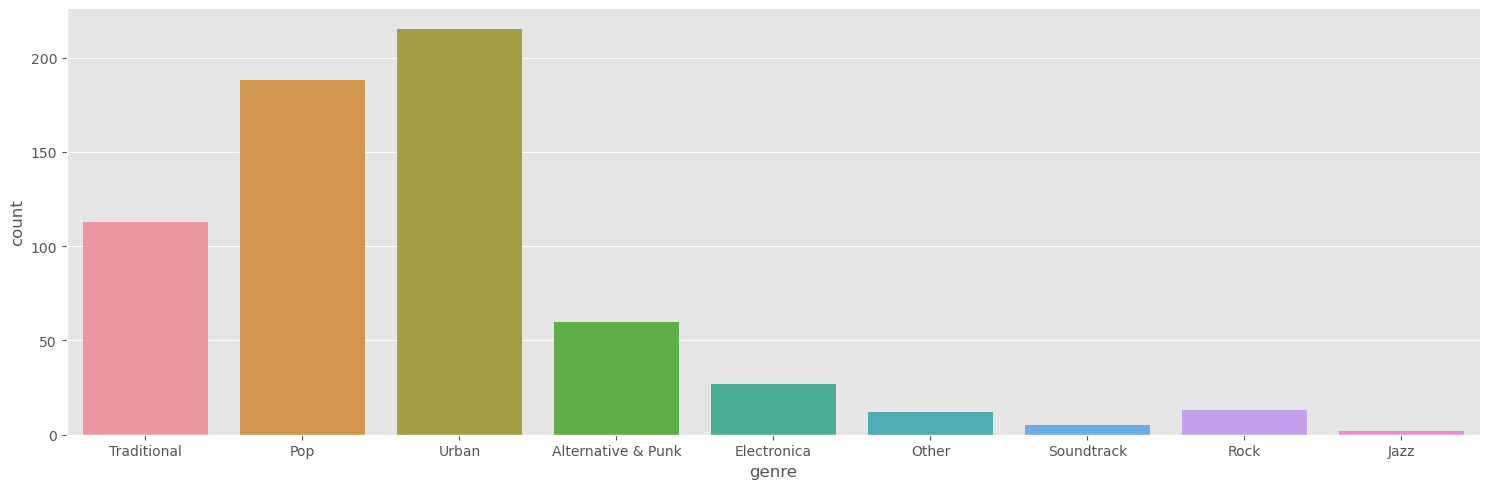

In [23]:
sns.catplot(x='genre', data=artists_billboard, kind='count', aspect=3)

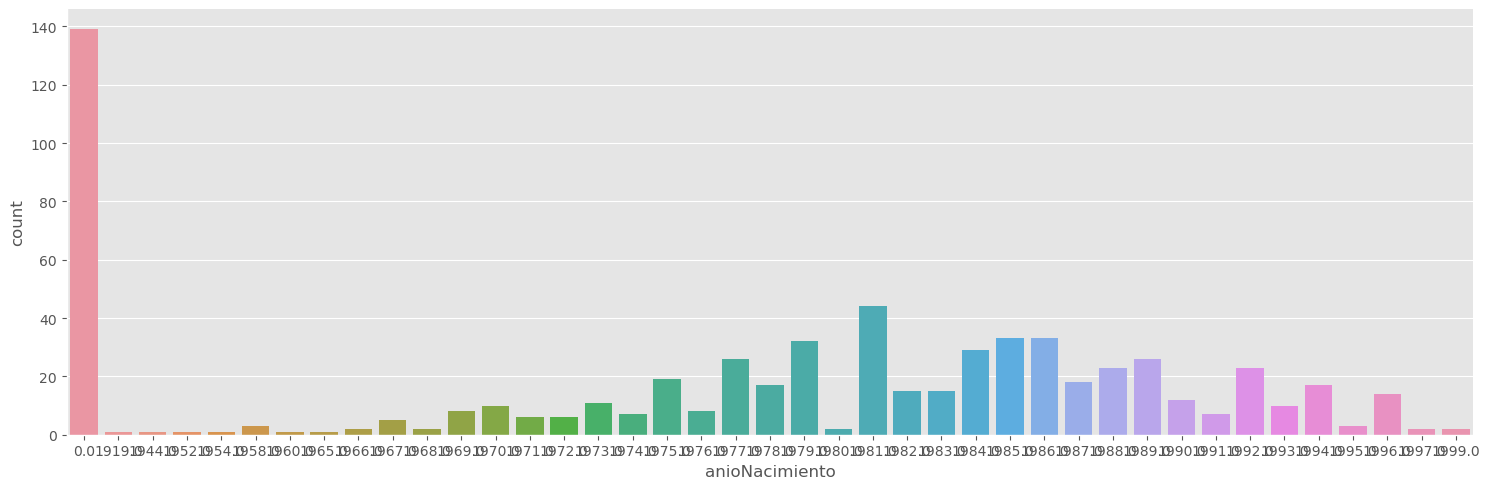

In [24]:
sns.catplot(x='anioNacimiento', data=artists_billboard, kind='count', aspect=3)

## 3. Balanceo de datos

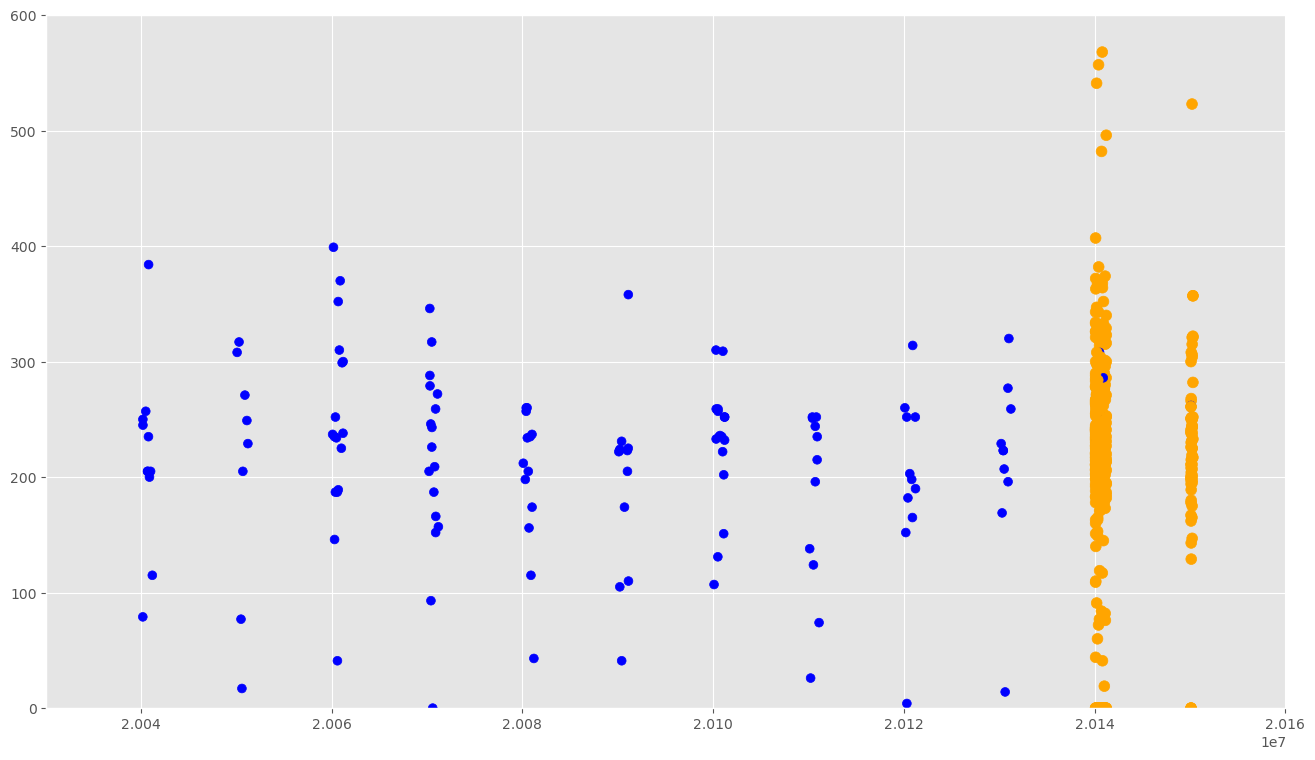

In [25]:
f1 = artists_billboard['chart_date'].values
f2 = artists_billboard['durationSeg'].values

colores = ['orange', 'blue']
tamanios = [60, 40]

asignar = []
asignar2 = []
for index, row in artists_billboard.iterrows():
    asignar.append(colores[row['top']])
    asignar2.append(tamanios[row['top']])

plt.scatter(f1, f2, c=asignar, s=asignar2)
plt.axis([20030101, 20160101, 0, 600])
plt.show()

### 3.1. Preparamos los datos

In [26]:
def edad_fix(anio):
    if anio == 0:
        return None
    return anio

artists_billboard['anioNacimiento'] = artists_billboard.apply(
    lambda x: edad_fix(x['anioNacimiento']),
    axis=1
)

In [27]:
def calcula_edad(anio, cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio == 0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard'] = artists_billboard.apply(
    lambda x: calcula_edad(x['anioNacimiento'], x['chart_date']),
    axis=1
)

In [28]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad promedio: " + str(age_avg))
print("Desviación Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg - age_std)))

Edad promedio: 30.10282258064516
Desviación Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 21


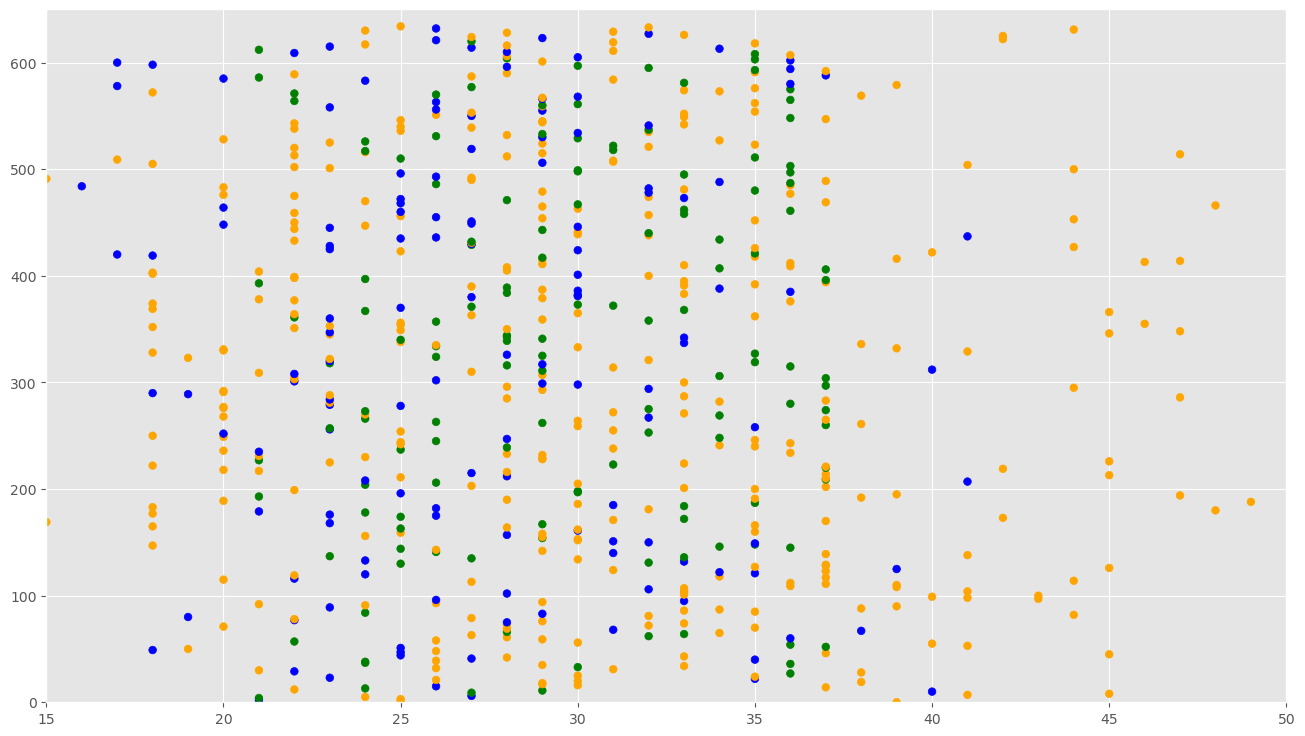

In [29]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange', 'blue', 'green']

asignar = []
for index, row in artists_billboard.iterrows():
    if (conValoresNulos[index]):
        asignar.append(colores[2])
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15, 50, 0, 650])
plt.show()

## 4. Mapeo de datos

In [31]:
# Mood mapping
artists_billboard['moodEncoded'] = artists_billboard['mood'].map({
    'Energizing': 6,
    'Empowering': 5,
    'Cool': 4,
    'Excited': 5,
    'Defiant': 3,
    'Sensual': 2,
    'Gritty': 3,
    'Sophisticated': 4,
    'Aggresive': 4,
    'Fiery': 4,
    'Urgent': 3,
    'Rowdy': 4,
    'Sentimental': 4,
    'Easygoing': 1,
    'Melancholy': 4,
    'Romantic': 2,
    'Peaceful': 1,
    'Brooding': 4,
    'Upbeat': 5,
    'Stirring': 5,
    'Lively': 5,
    'Other': 0,
    '': 0
})

# Tempo mapping
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map({
    'Fast Tempo': 0,
    'Medium Tempo': 2,
    'Slow Tempo': 1,
    '': 0
}).astype(int)

# Genre mapping
artists_billboard['genreEncoded'] = artists_billboard['genre'].map({
    'Urban': 4,
    'Pop': 3,
    'Traditional': 2,
    'Alternative & Punk': 1,
    'Electronica': 1,
    'Rock': 1,
    'Soundtrack': 0,
    'Jazz': 0,
    'Other': 0,
    '': 0
}).astype(int)

# artist_type mapping
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map({
    'Female': 2,
    'Male': 3,
    'Mixed': 1,
    '': 0
}).astype(int)

# Mapping edad en la que llegaron al billboard
artists_billboard.loc[artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[artists_billboard['edad_en_billboard'] <= 150, 'edadEncoded'] = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 150) & (artists_billboard['edad_en_billboard'] <= 180), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 180) & (artists_billboard['edad_en_billboard'] <= 210), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 210) & (artists_billboard['edad_en_billboard'] <= 240), 'edadEncoded'] = 3
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 240) & (artists_billboard['edad_en_billboard'] <= 270), 'edadEncoded'] = 4
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 270) & (artists_billboard['edad_en_billboard'] <= 300), 'edadEncoded'] = 5
artists_billboard.loc[artists_billboard['edad_en_billboard'] > 300, 'edadEncoded'] = 6

In [32]:
drop_elements = ['id', 'title', 'artist', 'mood', 'tempo', 'genre', 'artist_type', 'chart_date', 'anioNacimiento', 'durationSeg', 'edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis=1)